<a href="https://colab.research.google.com/github/AxelRK200/trend_finder_dataiku/blob/main/Exploration/PPS_Vs_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ppscore

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import math
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import ppscore as pps
from datetime import datetime

# Import et conversion

#### Dataframe index de référence 

In [3]:
df_index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/FRED/HistoricalData_1677687890094.csv")
df_index.drop(columns=['Volume','Open','High','Low'], inplace=True)
df_index.rename(columns={"Close/Last": "Close"}, inplace=True)
df_index.head(1)

,Date,Close
0,02/28/2023,12042.12


In [4]:
df_index["Date"] = pd.to_datetime(df_index["Date"])

In [5]:
df_index.sort_values(by="Date", ascending=True, inplace=True)
df_index.reset_index(drop=True, inplace=True)

In [6]:
df_index.head(1)

,Date,Close
0,2013-03-01,2747.75


In [7]:
df_index.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [8]:
df_index.isnull().sum()

Date     0
Close    0
dtype: int64

#### Datatframes indicateurs

In [9]:
path="/content/drive/MyDrive/Colab Notebooks/sources/FRED/"
sources_list = ["BAMLC0A0CMEY.csv","BAMLC0A0CM_spread.csv","BAMLH0A0HYM2.csv","BAMLH0A3HYCEY.csv","CBBTCUSD.csv","CBETHUSD.csv","DAAA.csv","DEXUSEU.csv","GVZCLS.csv","RVXCLS.csv","T10Y2Y-2.csv","VIXCLS.csv","VXDCLS.csv","VXNCLS.csv","WILL5000PR.csv"]

In [22]:
def clean_incorrect_values(df):
  ''' identifie les lignes contenant "." au lieu d'une valeur
  et attribue Nan à la place. Cela permettra ensuite une interpolation'''

  col_list = df.columns.to_list()

  # remplace les valeurs "." par NaN
  indexes_to_replace = df[df[col_list[1]]=="."].index.to_list() 
  df.loc[indexes_to_replace,col_list[1]] = math.nan

  # convertions d'objet vers float, possible avec NaN 
  df[col_list[1]] = df[col_list[1]].astype(float)

  # interpolation linéaire pour combler les valeurs NaN
  df[col_list[1]].interpolate(methode='linear', inplace=True)

  # renommage avant jointure
  df.rename(columns={"DATE": "Date"}, inplace=True)
  
  return df

In [46]:
df_agg = df_index.copy()

for indicateur in sources_list:
  
  df_temp = pd.read_csv(path+indicateur)

  # Conversion de la date format obj -> datetime
  df_temp["DATE"] = pd.to_datetime(df_temp["DATE"])

  df_temp = clean_incorrect_values(df_temp)

  if df_temp.isnull().sum().all() == 0:
    print("Conversion ok pour "+indicateur)

    df_agg = df_agg.merge(df_temp, how='left', on='Date')

Conversion ok pour BAMLC0A0CMEY.csv
Conversion ok pour BAMLC0A0CM_spread.csv
Conversion ok pour BAMLH0A0HYM2.csv
Conversion ok pour BAMLH0A3HYCEY.csv
Conversion ok pour CBBTCUSD.csv
Conversion ok pour CBETHUSD.csv
Conversion ok pour DAAA.csv
Conversion ok pour DEXUSEU.csv
Conversion ok pour GVZCLS.csv
Conversion ok pour RVXCLS.csv
Conversion ok pour T10Y2Y-2.csv
Conversion ok pour VIXCLS.csv
Conversion ok pour VXDCLS.csv
Conversion ok pour VXNCLS.csv
Conversion ok pour WILL5000PR.csv


In [47]:
df_agg.columns

Index(['Date', 'Close', 'BAMLC0A0CMEY', 'BAMLC0A0CM', 'BAMLH0A0HYM2',
       'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'DEXUSEU', 'GVZCLS',
       'RVXCLS', 'T10Y2Y', 'VIXCLS', 'VXDCLS', 'VXNCLS', 'WILL5000PR'],
      dtype='object')

In [49]:
df_agg.describe()

,Close,BAMLC0A0CMEY,BAMLC0A0CM,BAMLH0A0HYM2,BAMLH0A3HYCEY,CBBTCUSD,CBETHUSD,DAAA,DEXUSEU,GVZCLS,RVXCLS,T10Y2Y,VIXCLS,VXDCLS,VXNCLS,WILL5000PR
count,2541.000000,2541.000000,2541.000000,2540.000000,2541.000000,2085.000000,1707.000000,2541.000000,2539.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000
mean,7490.469677,3.253133,1.324707,4.470937,11.357859,13279.398346,916.364118,3.640069,1.165063,16.576348,22.511891,0.942357,17.931244,17.270911,21.148863,28560.652544
std,3798.296513,0.803160,0.307725,1.126374,2.884762,16166.770426,1125.938584,0.664499,0.094304,4.508745,8.106930,0.766059,7.323458,6.765146,7.845344,8913.547486
min,2741.950000,1.790000,0.860000,3.010000,6.520000,120.000000,6.750000,2.010000,0.961600,8.880000,11.830000,-0.890000,9.140000,2.710000,10.310000,15738.230000
25%,4381.300000,2.880000,1.130000,3.680000,9.530000,773.220000,166.550000,3.220000,1.103200,13.250000,17.050000,0.300000,13.060000,12.960000,15.320000,21241.810000
50%,6526.960000,3.180000,1.290000,4.190000,10.610000,7424.900000,326.990000,3.800000,1.137250,16.040000,19.720000,0.910000,15.800000,15.250000,18.400000,27015.830000
75%,10906.340000,3.590000,1.480000,4.912500,12.790000,18550.010000,1434.145000,4.070000,1.207600,19.070000,26.040000,1.450000,21.130000,19.730000,26.120000,34174.770000
max,16573.340000,6.140000,4.010000,10.870000,21.680000,67510.060000,4805.950000,5.410000,1.392700,48.980000,83.190000,2.660000,82.690000,67.070000,80.080000,49174.620000


# EDA

## On raw data

array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CMEY'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CM'}>],
       [<AxesSubplot:title={'center':'BAMLH0A0HYM2'}>,
        <AxesSubplot:title={'center':'BAMLH0A3HYCEY'}>,
        <AxesSubplot:title={'center':'CBBTCUSD'}>,
        <AxesSubplot:title={'center':'CBETHUSD'}>],
       [<AxesSubplot:title={'center':'DAAA'}>,
        <AxesSubplot:title={'center':'DEXUSEU'}>,
        <AxesSubplot:title={'center':'GVZCLS'}>,
        <AxesSubplot:title={'center':'RVXCLS'}>],
       [<AxesSubplot:title={'center':'T10Y2Y'}>,
        <AxesSubplot:title={'center':'VIXCLS'}>,
        <AxesSubplot:title={'center':'VXDCLS'}>,
        <AxesSubplot:title={'center':'VXNCLS'}>],
       [<AxesSubplot:title={'center':'WILL5000PR'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

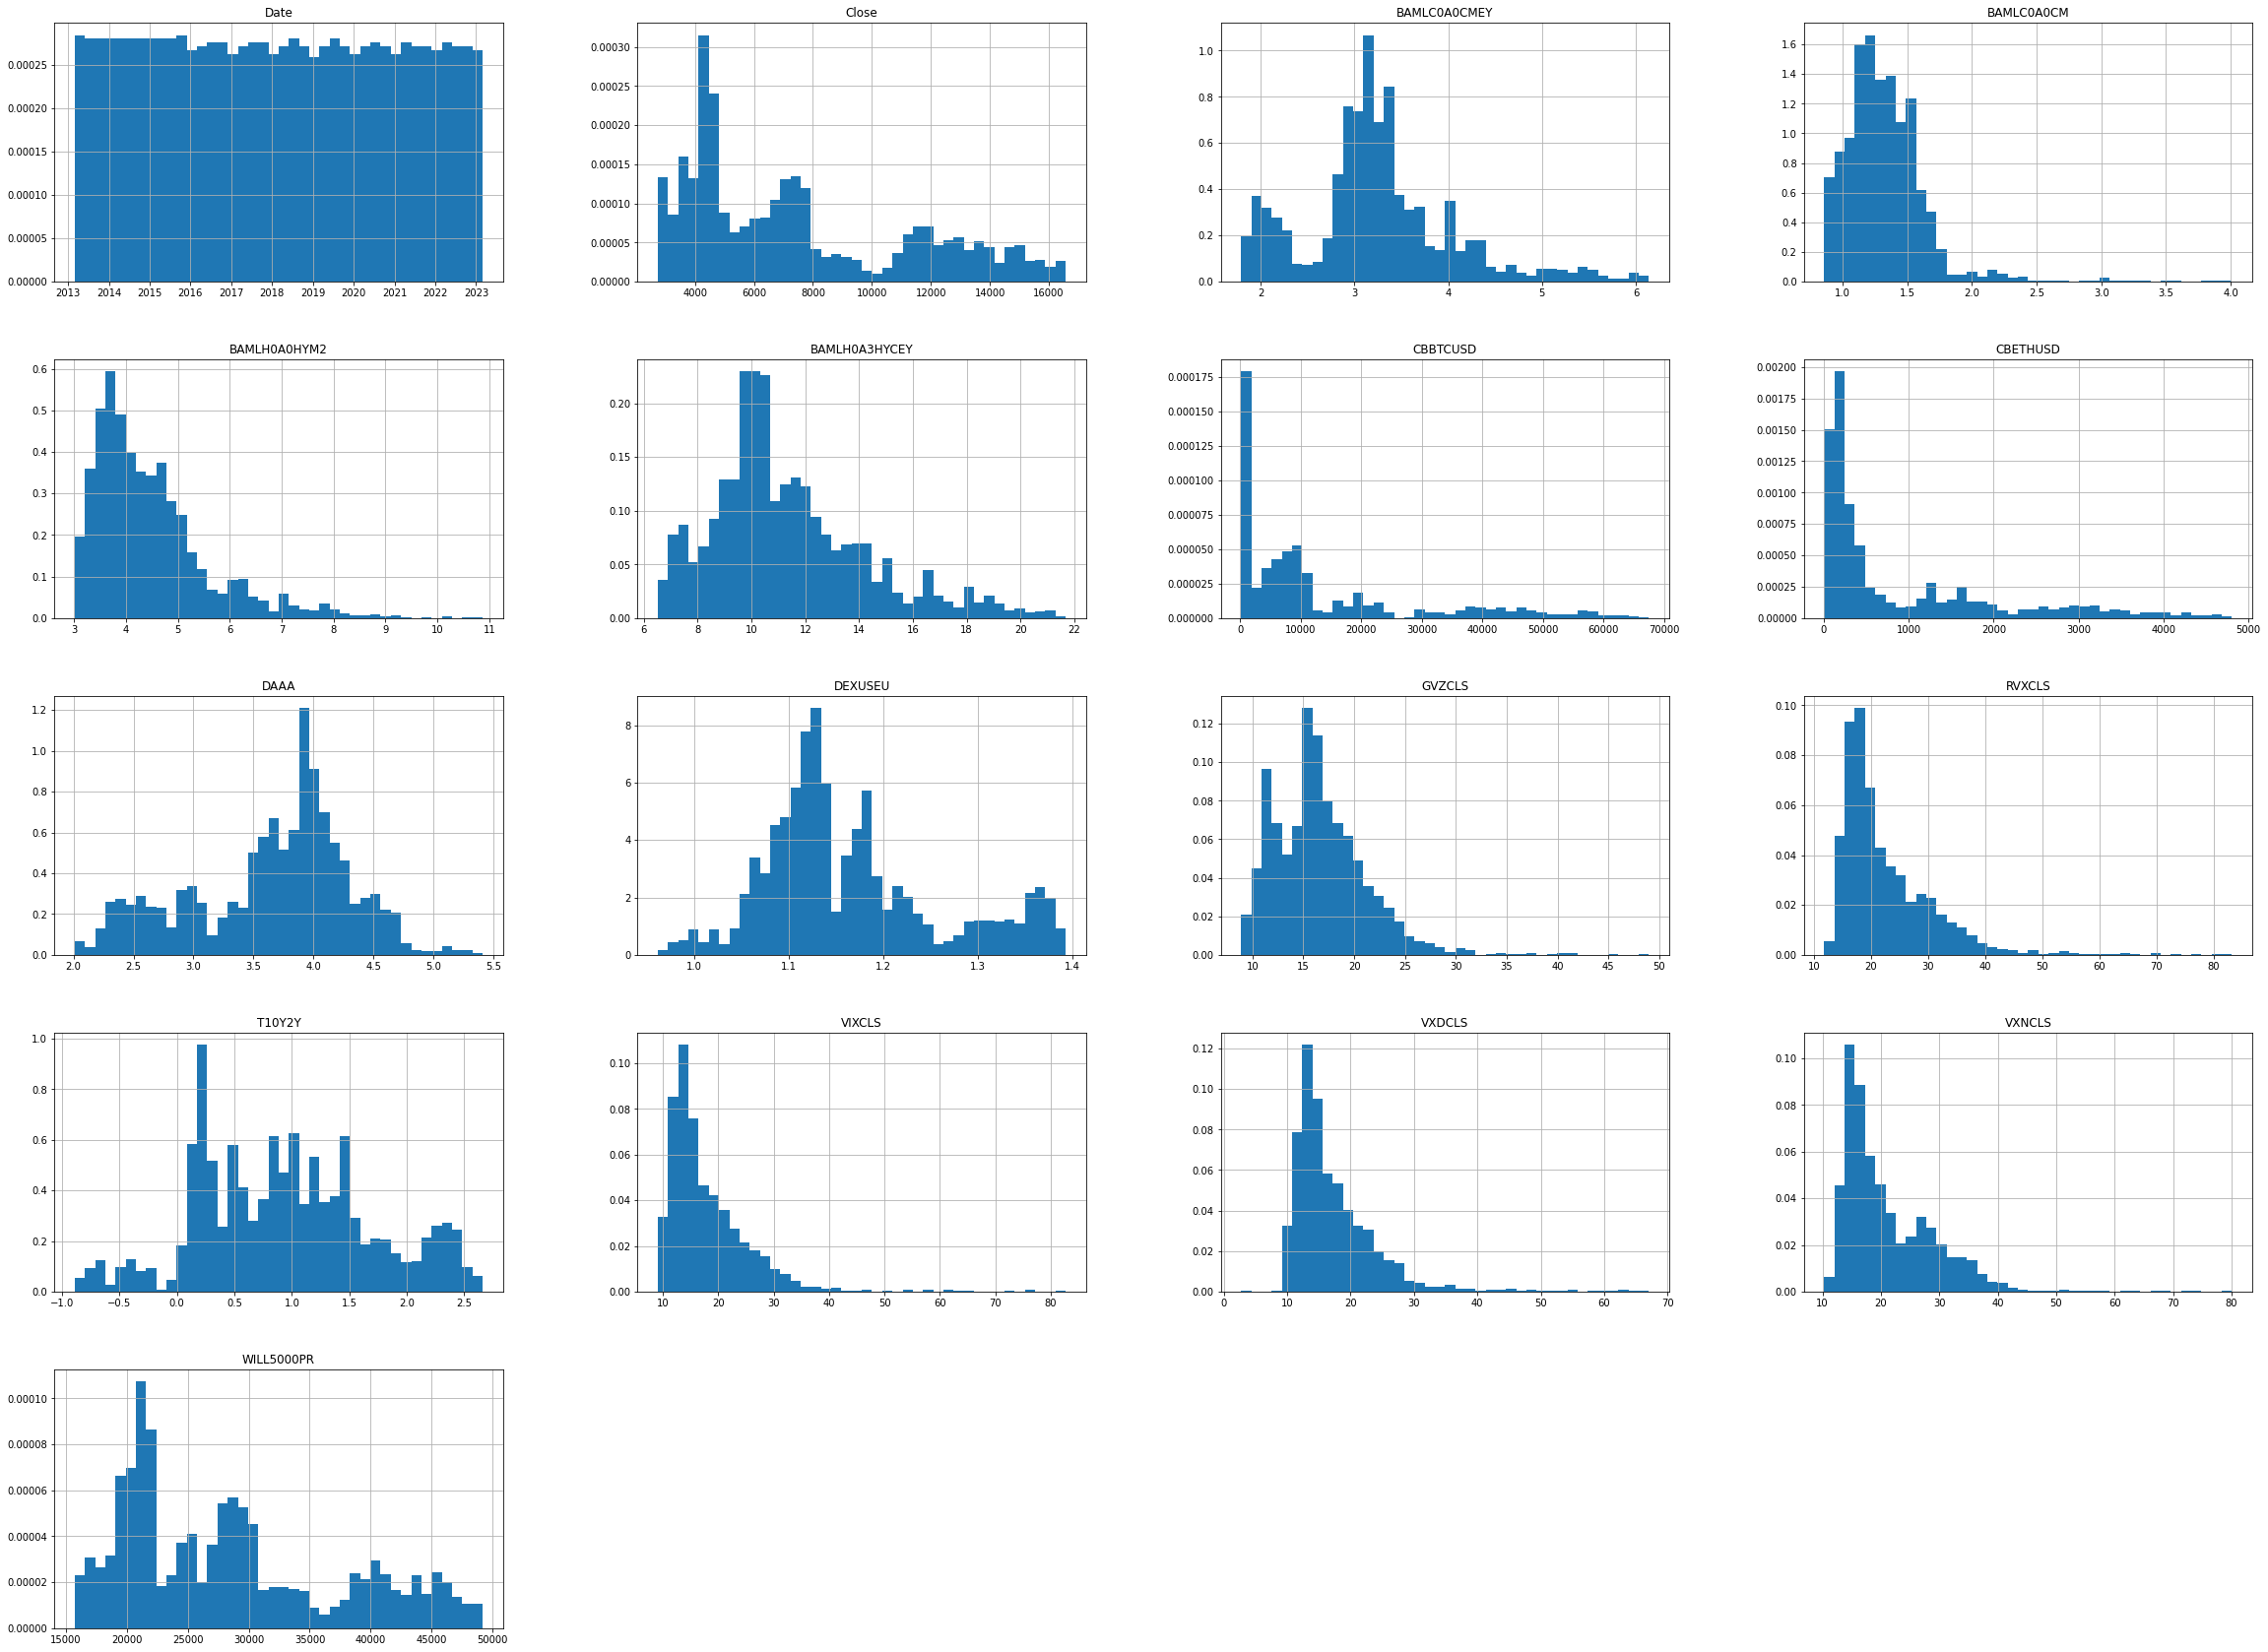

In [50]:
df_agg.hist(figsize=(40,30),bins=40, density=True)

In [52]:
matrix = df_agg.drop(columns=["Date"]).corr()

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<AxesSubplot:>

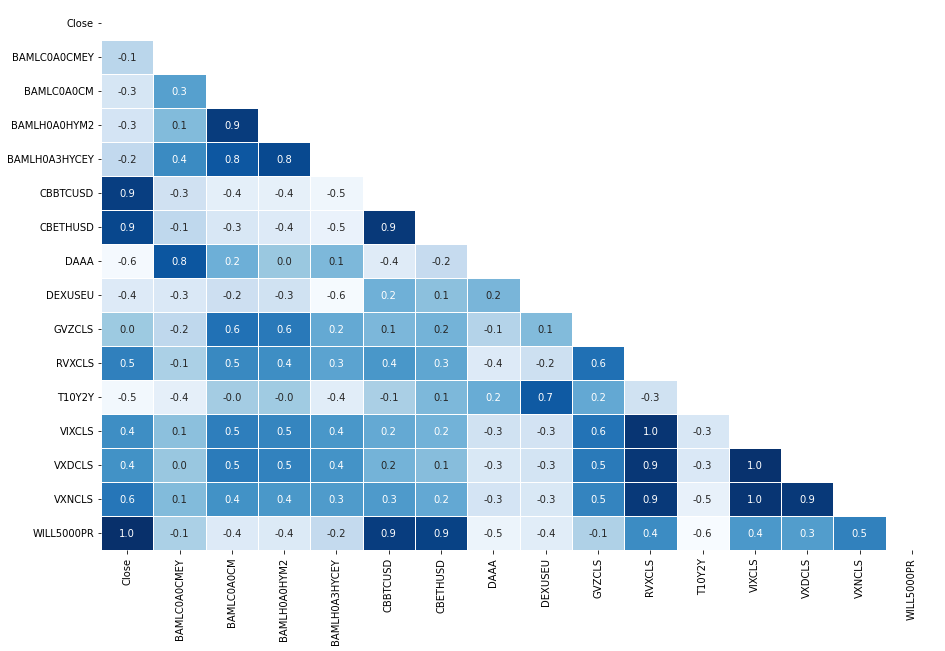

In [56]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [60]:
predictors_df = pps.predictors(df_agg.drop(columns=["Date"]), y='Close')
predictors_df

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,WILL5000PR,Close,0.885233,regression,True,mean absolute error,3071.965301,352.560476,DecisionTreeRegressor()
1,CBBTCUSD,Close,0.759053,regression,True,mean absolute error,2990.117592,720.458786,DecisionTreeRegressor()
2,CBETHUSD,Close,0.627278,regression,True,mean absolute error,2948.104575,1098.824838,DecisionTreeRegressor()
3,BAMLC0A0CMEY,Close,0.477829,regression,True,mean absolute error,3071.965301,1604.092082,DecisionTreeRegressor()
4,DAAA,Close,0.307023,regression,True,mean absolute error,3071.965301,2128.801525,DecisionTreeRegressor()
5,T10Y2Y,Close,0.278015,regression,True,mean absolute error,3071.965301,2217.912348,DecisionTreeRegressor()
6,RVXCLS,Close,0.240722,regression,True,mean absolute error,3071.965301,2332.474411,DecisionTreeRegressor()
7,BAMLC0A0CM,Close,0.197522,regression,True,mean absolute error,3071.965301,2465.183635,DecisionTreeRegressor()
8,BAMLH0A3HYCEY,Close,0.194955,regression,True,mean absolute error,3071.965301,2473.070551,DecisionTreeRegressor()
9,DEXUSEU,Close,0.169026,regression,True,mean absolute error,3070.033371,2551.118156,DecisionTreeRegressor()


[Text(0, 0, '0.885233'),
 Text(0, 0, '0.759053'),
 Text(0, 0, '0.627278'),
 Text(0, 0, '0.477829'),
 Text(0, 0, '0.307023'),
 Text(0, 0, '0.278015'),
 Text(0, 0, '0.240722'),
 Text(0, 0, '0.197522'),
 Text(0, 0, '0.194955'),
 Text(0, 0, '0.169026'),
 Text(0, 0, '0.160476'),
 Text(0, 0, '0.13127'),
 Text(0, 0, '0.0960387'),
 Text(0, 0, '0.0808628'),
 Text(0, 0, '0')]

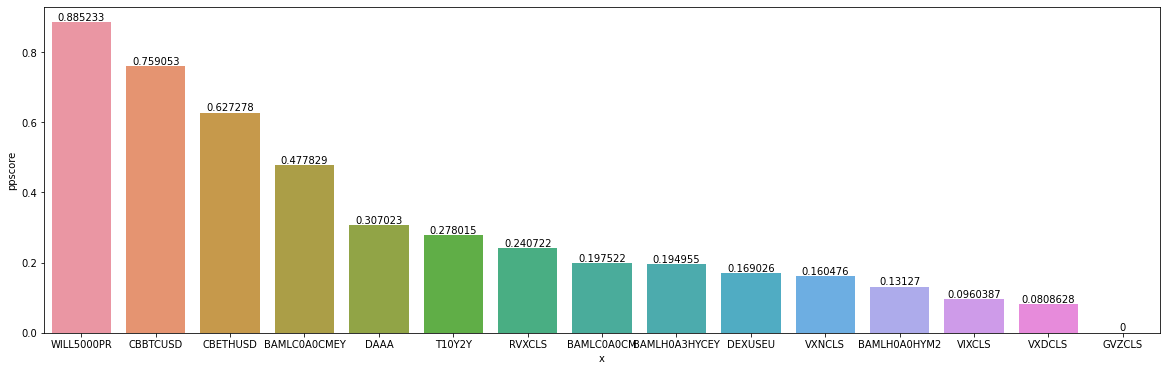

In [68]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

## Données normalisées
On va étudier ici les variations en % par rapport au résultat de la veille, plutôt que les valeurs brutes, puis en Ln, et enfin converti en base 1000

### En %

In [71]:
def daily_var(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( ((df_dailyR[col] - df_dailyR[col].shift(1))/df_dailyR[col].shift(1))*100, 2)
  
  return df_dailyR

In [78]:
df_norm = daily_var(df_agg)
df_norm.dropna(subset=['Close'], inplace=True)
df_norm.reset_index(drop=True, inplace=True)
df_norm.head()

,Date,Close,BAMLC0A0CMEY,BAMLC0A0CM,BAMLH0A0HYM2,BAMLH0A3HYCEY,CBBTCUSD,CBETHUSD,DAAA,DEXUSEU,GVZCLS,RVXCLS,T10Y2Y,VIXCLS,VXDCLS,VXNCLS,WILL5000PR
0,2013-03-04,0.43,0.36,0.00,-0.40,-0.10,NaN,NaN,0.52,0.06,1.78,-2.02,1.86,-8.79,-6.17,-1.60,0.44
1,2013-03-05,1.44,0.00,-0.67,-1.20,-0.83,NaN,NaN,0.52,0.18,-3.49,-6.35,0.61,-3.78,-3.05,-5.13,0.98
2,2013-03-06,-0.24,1.07,-0.68,-0.81,-0.31,NaN,NaN,1.03,-0.22,-2.71,-1.01,3.03,0.37,0.48,0.00,0.13
3,2013-03-07,0.25,1.06,-0.68,-1.43,-0.42,NaN,NaN,1.28,0.83,-1.40,-3.06,2.94,-3.47,-3.22,-2.53,0.24
4,2013-03-08,0.17,1.05,-0.68,-1.04,-0.11,NaN,NaN,1.52,-0.81,-8.76,-4.58,2.29,-3.60,-3.32,-3.58,0.49


In [88]:
df_norm.describe()

,Close,BAMLC0A0CMEY,BAMLC0A0CM,BAMLH0A0HYM2,BAMLH0A3HYCEY,CBBTCUSD,CBETHUSD,DAAA,DEXUSEU,GVZCLS,RVXCLS,T10Y2Y,VIXCLS,VXDCLS,VXNCLS,WILL5000PR
count,2540.000000,2540.000000,2540.000000,2539.000000,2540.000000,2084.000000,1706.000000,2540.000000,2538.000000,2540.000000,2540.000000,2539.00,2540.000000,2540.000000,2540.000000,2540.000000
mean,0.067323,0.035331,0.003752,0.012627,0.022531,0.318748,0.506835,0.019976,-0.006998,0.131185,0.205339,NaN,0.338622,0.426823,0.246449,0.043543
std,1.345748,1.285340,1.371054,1.987062,1.158287,4.879063,6.777596,1.520740,0.488946,5.323543,6.391709,NaN,8.480112,12.071696,6.912945,1.120965
min,-12.190000,-7.370000,-7.770000,-9.650000,-9.080000,-53.850000,-43.090000,-13.350000,-2.640000,-23.330000,-30.530000,-inf,-25.910000,-81.760000,-23.570000,-12.290000
25%,-0.460000,-0.670000,-0.720000,-1.050000,-0.510000,-1.560000,-2.665000,-0.800000,-0.270000,-2.940000,-3.512500,-2.21,-4.322500,-3.842500,-3.690000,-0.380000
50%,0.110000,0.000000,0.000000,-0.130000,-0.070000,0.190000,0.065000,0.000000,-0.010000,-0.420000,-0.350000,0.00,-0.695000,-0.510000,-0.480000,0.070000
75%,0.720000,0.670000,0.620000,0.875000,0.470000,2.132500,3.430000,0.780000,0.260000,2.432500,2.970000,2.08,3.640000,3.240000,3.200000,0.540000
max,10.070000,14.250000,26.170000,18.440000,9.450000,70.180000,49.170000,18.060000,3.110000,61.730000,71.680000,inf,115.600000,472.320000,59.830000,9.400000


In [89]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_norm.copy()
df_hist.drop(columns=['Date','T10Y2Y'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [90]:
matrix_norm = df_norm.drop(columns=["Date"]).corr()

<AxesSubplot:>

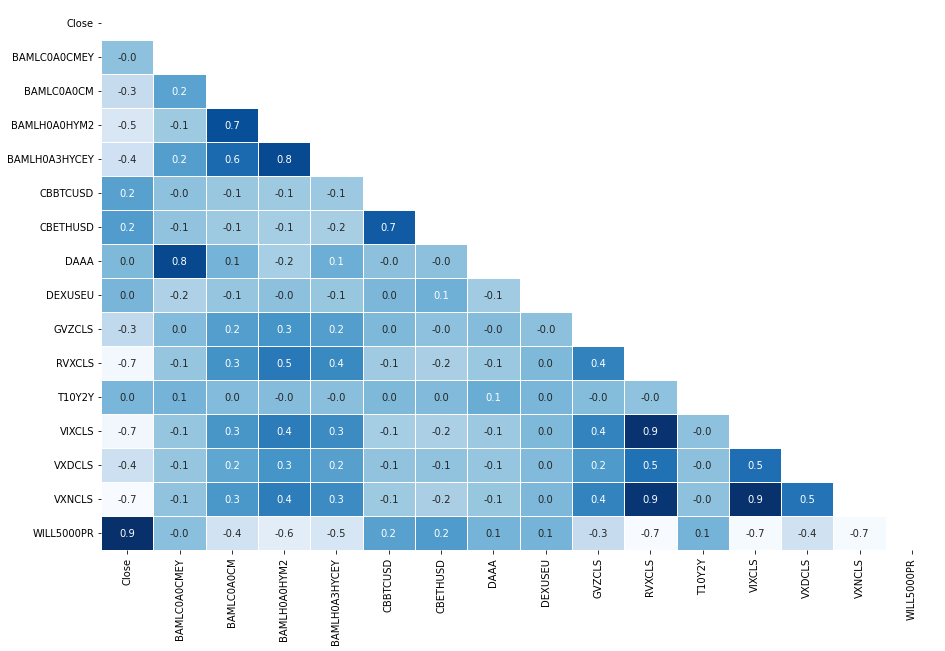

In [91]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_norm, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_norm, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [93]:
predictors_df_norm = pps.predictors(df_norm.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_norm

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,WILL5000PR,Close,0.544101,regression,True,mean absolute error,0.906189,0.413131,DecisionTreeRegressor()
1,VXNCLS,Close,0.066054,regression,True,mean absolute error,0.906189,0.846331,DecisionTreeRegressor()
2,VIXCLS,Close,0.018467,regression,True,mean absolute error,0.906189,0.889454,DecisionTreeRegressor()
3,BAMLC0A0CMEY,Close,0.000000,regression,True,mean absolute error,0.906189,1.080714,DecisionTreeRegressor()
4,BAMLC0A0CM,Close,0.000000,regression,True,mean absolute error,0.906189,1.007325,DecisionTreeRegressor()
5,BAMLH0A0HYM2,Close,0.000000,regression,True,mean absolute error,0.906451,1.030990,DecisionTreeRegressor()
6,BAMLH0A3HYCEY,Close,0.000000,regression,True,mean absolute error,0.906189,1.010393,DecisionTreeRegressor()
7,CBBTCUSD,Close,0.000000,regression,True,mean absolute error,0.973234,1.347340,DecisionTreeRegressor()
8,CBETHUSD,Close,0.000000,regression,True,mean absolute error,1.005311,1.406600,DecisionTreeRegressor()
9,DAAA,Close,0.000000,regression,True,mean absolute error,0.906189,1.112051,DecisionTreeRegressor()


[Text(0, 0, '0.544101'),
 Text(0, 0, '0.0660541'),
 Text(0, 0, '0.018467'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

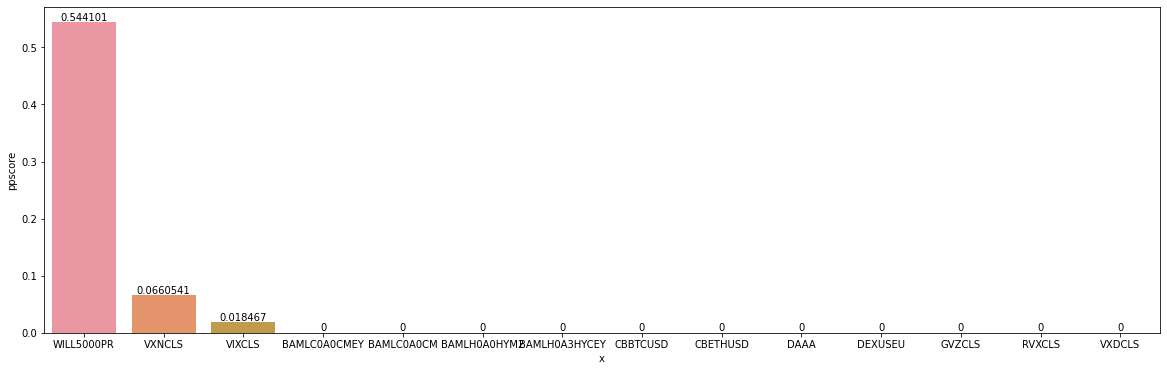

In [94]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_norm, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En Ln (résulats identiques à %)

In [95]:
def daily_var_ln(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( np.log(df_dailyR[col]/df_dailyR[col].shift(1)), 2)
  
  return df_dailyR

In [96]:
df_Ln = daily_var(df_agg)
df_Ln.dropna(subset=['Close'], inplace=True)
df_Ln.reset_index(drop=True, inplace=True)
df_Ln.head()

,Date,Close,BAMLC0A0CMEY,BAMLC0A0CM,BAMLH0A0HYM2,BAMLH0A3HYCEY,CBBTCUSD,CBETHUSD,DAAA,DEXUSEU,GVZCLS,RVXCLS,T10Y2Y,VIXCLS,VXDCLS,VXNCLS,WILL5000PR
0,2013-03-04,0.43,0.36,0.00,-0.40,-0.10,NaN,NaN,0.52,0.06,1.78,-2.02,1.86,-8.79,-6.17,-1.60,0.44
1,2013-03-05,1.44,0.00,-0.67,-1.20,-0.83,NaN,NaN,0.52,0.18,-3.49,-6.35,0.61,-3.78,-3.05,-5.13,0.98
2,2013-03-06,-0.24,1.07,-0.68,-0.81,-0.31,NaN,NaN,1.03,-0.22,-2.71,-1.01,3.03,0.37,0.48,0.00,0.13
3,2013-03-07,0.25,1.06,-0.68,-1.43,-0.42,NaN,NaN,1.28,0.83,-1.40,-3.06,2.94,-3.47,-3.22,-2.53,0.24
4,2013-03-08,0.17,1.05,-0.68,-1.04,-0.11,NaN,NaN,1.52,-0.81,-8.76,-4.58,2.29,-3.60,-3.32,-3.58,0.49


In [98]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_Ln.copy()
df_hist.drop(columns=['Date','T10Y2Y'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [99]:
matrix_Ln = df_Ln.drop(columns=["Date"]).corr()

<AxesSubplot:>

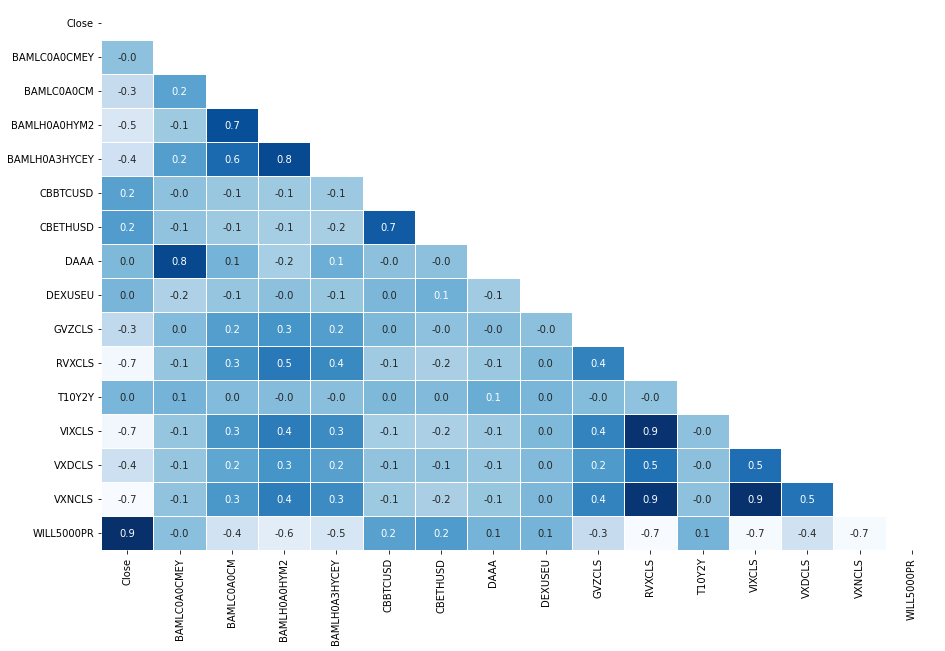

In [100]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_Ln, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_Ln, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [101]:
predictors_df_Ln = pps.predictors(df_Ln.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_Ln

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,WILL5000PR,Close,0.544101,regression,True,mean absolute error,0.906189,0.413131,DecisionTreeRegressor()
1,VXNCLS,Close,0.066054,regression,True,mean absolute error,0.906189,0.846331,DecisionTreeRegressor()
2,VIXCLS,Close,0.018467,regression,True,mean absolute error,0.906189,0.889454,DecisionTreeRegressor()
3,BAMLC0A0CMEY,Close,0.000000,regression,True,mean absolute error,0.906189,1.080714,DecisionTreeRegressor()
4,BAMLC0A0CM,Close,0.000000,regression,True,mean absolute error,0.906189,1.007325,DecisionTreeRegressor()
5,BAMLH0A0HYM2,Close,0.000000,regression,True,mean absolute error,0.906451,1.030990,DecisionTreeRegressor()
6,BAMLH0A3HYCEY,Close,0.000000,regression,True,mean absolute error,0.906189,1.010393,DecisionTreeRegressor()
7,CBBTCUSD,Close,0.000000,regression,True,mean absolute error,0.973234,1.347340,DecisionTreeRegressor()
8,CBETHUSD,Close,0.000000,regression,True,mean absolute error,1.005311,1.406600,DecisionTreeRegressor()
9,DAAA,Close,0.000000,regression,True,mean absolute error,0.906189,1.112051,DecisionTreeRegressor()


[Text(0, 0, '0.544101'),
 Text(0, 0, '0.0660541'),
 Text(0, 0, '0.018467'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

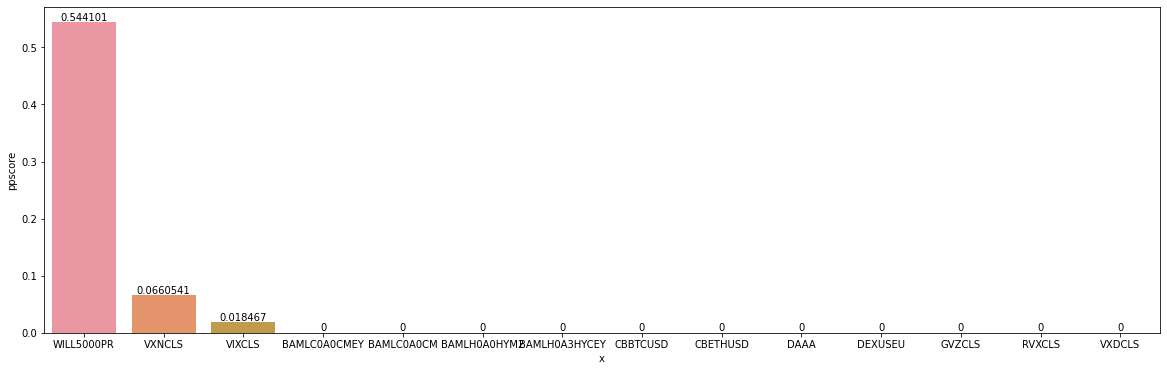

In [102]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_Ln, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En base 1000

In [155]:
# Fonction pour normaliser les valeurs base 1000
def normalize(df):
  df_norm = df.copy()
  col_list = df.columns
  for element in col_list[1:]:
    df_norm[element] = df_norm[element].apply(lambda x: (x/(df_norm.loc[0,element])*1000))
  return df_norm

In [156]:
# Fonction de visualisation avec Plotly
def interactif_plot(df, titre):
  fig = px.line(title = titre)

  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name =i)

  fig.show()

In [162]:
df_base1000 = df_agg.dropna()
df_base1000.reset_index(drop=True, inplace=True)

In [164]:
df_base1000 = normalize(df_base1000)
interactif_plot(df_base1000,'Variation base 1000')

In [165]:
matrix_1000 = df_base1000.drop(columns=["Date"]).corr()

<AxesSubplot:>

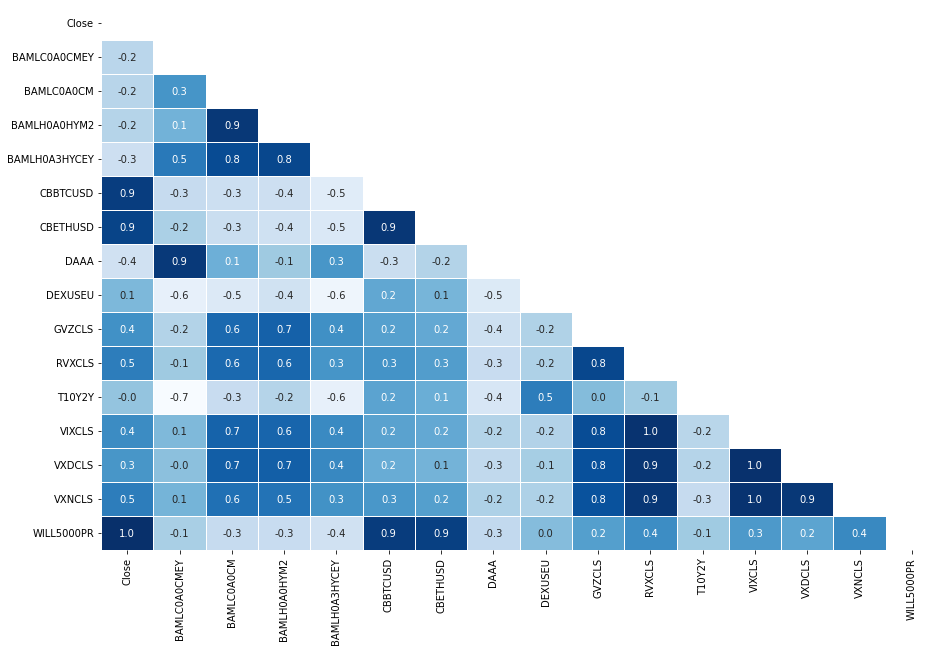

In [166]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_1000, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_1000, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

Les correlations sont vérifiées et globalement pour celles >=0.5, incrémentées de +- 0.1/0.2, converti en base 1000

In [167]:
predictors_df_base1000 = pps.predictors(df_base1000.drop(columns=["Date"]), y='Close')
predictors_df_base1000

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,WILL5000PR,Close,0.851628,regression,True,mean absolute error,679.231256,100.778851,DecisionTreeRegressor()
1,CBBTCUSD,Close,0.709756,regression,True,mean absolute error,679.231256,197.142841,DecisionTreeRegressor()
2,CBETHUSD,Close,0.631983,regression,True,mean absolute error,679.231256,249.968396,DecisionTreeRegressor()
3,BAMLC0A0CMEY,Close,0.482801,regression,True,mean absolute error,679.231256,351.297928,DecisionTreeRegressor()
4,BAMLH0A3HYCEY,Close,0.346310,regression,True,mean absolute error,679.231256,444.006660,DecisionTreeRegressor()
5,RVXCLS,Close,0.340857,regression,True,mean absolute error,679.231256,447.710803,DecisionTreeRegressor()
6,DAAA,Close,0.338299,regression,True,mean absolute error,679.231256,449.448245,DecisionTreeRegressor()
7,T10Y2Y,Close,0.230159,regression,True,mean absolute error,679.231256,522.900061,DecisionTreeRegressor()
8,VIXCLS,Close,0.217313,regression,True,mean absolute error,679.231256,531.625785,DecisionTreeRegressor()
9,BAMLC0A0CM,Close,0.217204,regression,True,mean absolute error,679.231256,531.699405,DecisionTreeRegressor()


[Text(0, 0, '0.851628'),
 Text(0, 0, '0.709756'),
 Text(0, 0, '0.631983'),
 Text(0, 0, '0.482801'),
 Text(0, 0, '0.34631'),
 Text(0, 0, '0.340857'),
 Text(0, 0, '0.338299'),
 Text(0, 0, '0.230159'),
 Text(0, 0, '0.217313'),
 Text(0, 0, '0.217204'),
 Text(0, 0, '0.204273'),
 Text(0, 0, '0.164702'),
 Text(0, 0, '0.151614'),
 Text(0, 0, '0.145344'),
 Text(0, 0, '0')]

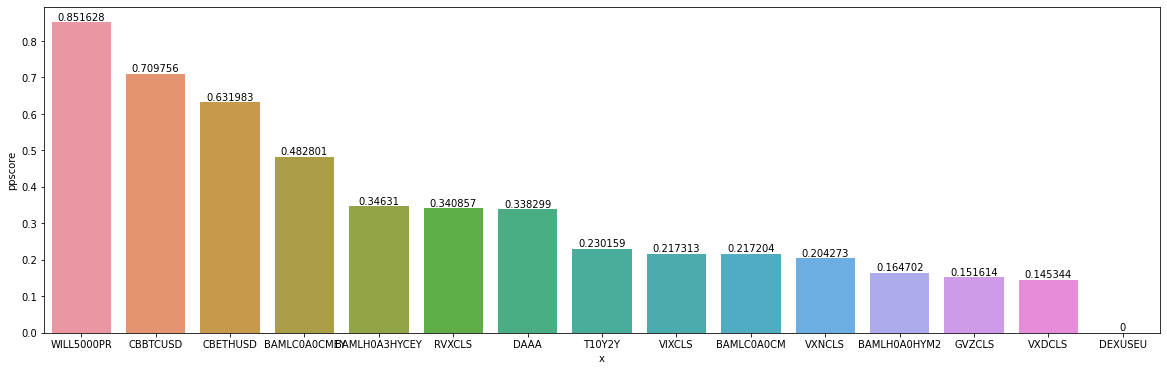

In [168]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_base1000, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

Ici le résultat est globalement identique pour le Top 4, comparativement entre base 1000 et mesures brutes.<br>
Toutefois l'ordre change pour les valeurs autour de 0.3 (seuil bas, peut-être à ne même pas prendre en considération)

# BTC, ETH & WILL5000 shift

## ACF, PACF

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [134]:
df_shifted = df_norm[['Date','Close','CBBTCUSD','CBETHUSD','WILL5000PR']]
df_shifted.dropna(inplace=True)
df_shifted.reset_index(drop=True, inplace=True)

In [135]:
df_shifted.head(1)

,Date,Close,CBBTCUSD,CBETHUSD,WILL5000PR
0,2016-05-19,-0.52,-3.77,13.05,-0.39


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



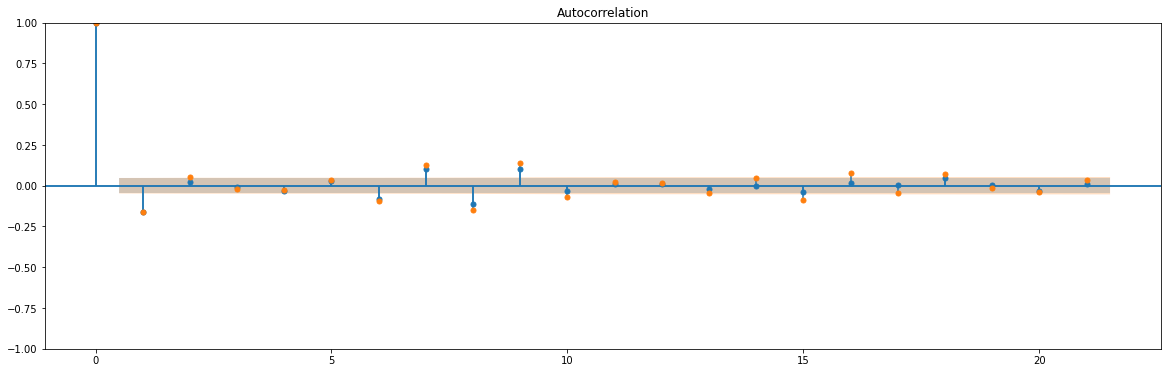

In [136]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["Close"], lags=21, ax=ax)
plot_acf(df_shifted["Close"], lags=21, ax=ax)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



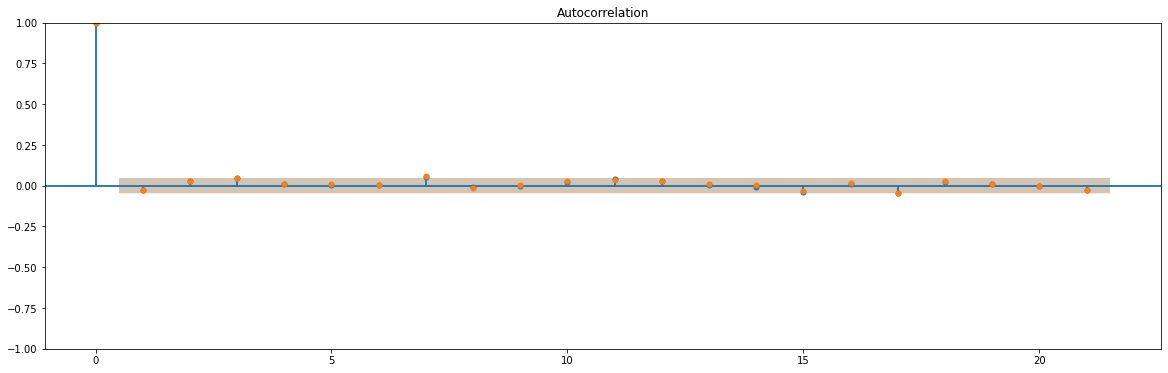

In [137]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["CBBTCUSD"], lags=21, ax=ax)
plot_acf(df_shifted["CBBTCUSD"], lags=21, ax=ax)
plt.show()

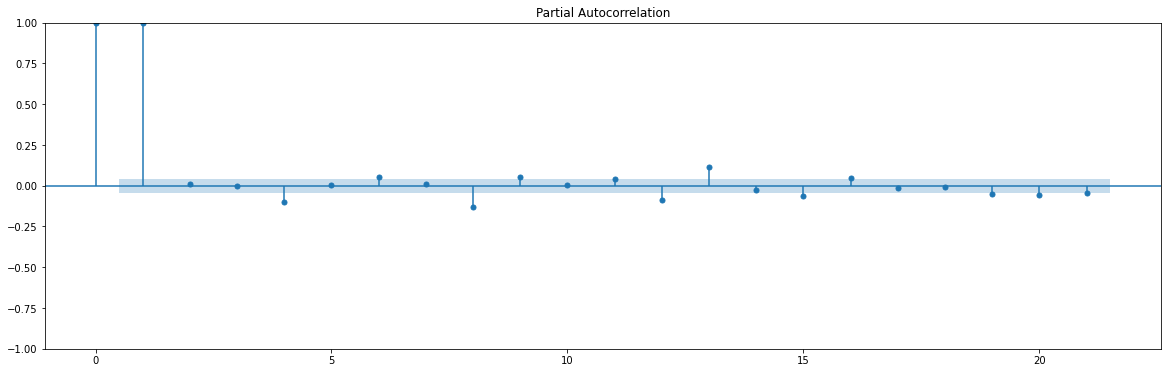

In [151]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_agg["CBBTCUSD"].dropna(), lags=21, ax=ax)
plt.show()

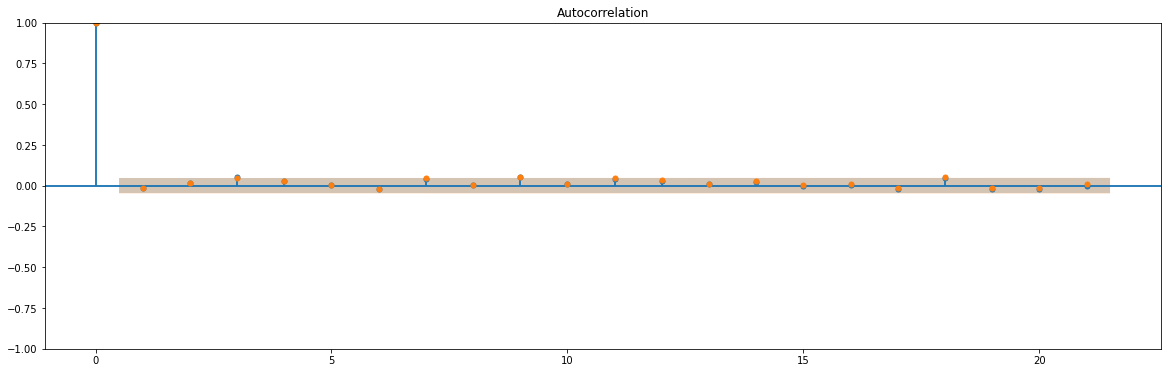

In [138]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["CBETHUSD"], lags=21, ax=ax)
plot_acf(df_shifted["CBETHUSD"], lags=21, ax=ax)
plt.show()

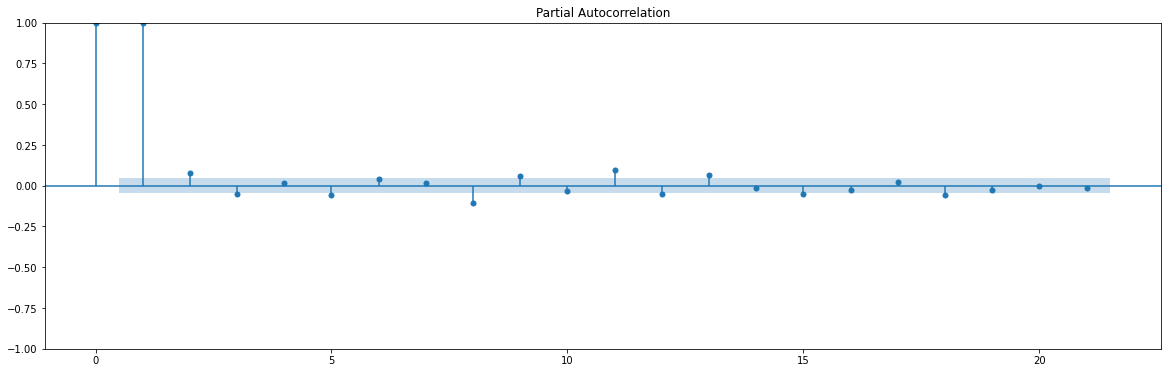

In [146]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_agg["CBETHUSD"].dropna(), lags=21, ax=ax)
plt.show()

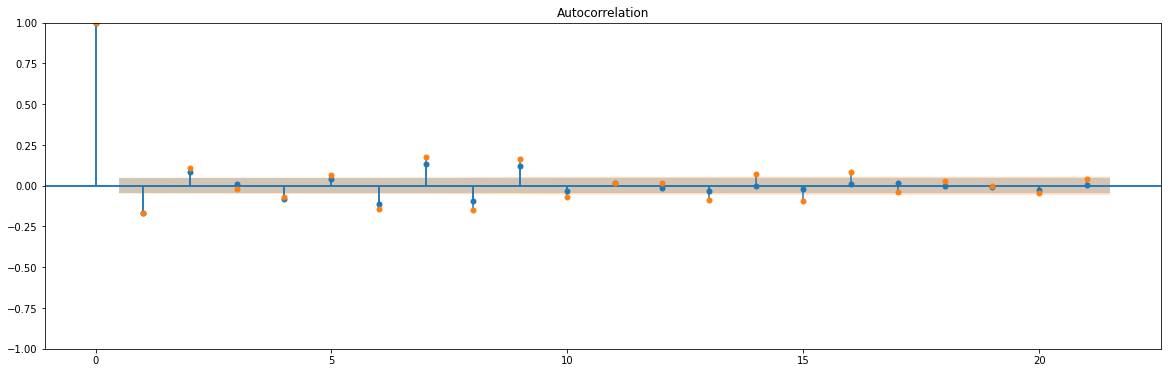

In [139]:
fig, ax = plt.subplots(figsize=(20, 6))
plot_pacf(df_shifted["WILL5000PR"], lags=21, ax=ax)
plot_acf(df_shifted["WILL5000PR"], lags=21, ax=ax)
plt.show()

Conclusion :<br>
Pour BTC & ETH (raw) : 1, 8<br>
Pour Close : 1(raw), 2(raw slt) 7, 8(raw), 9, 10(raw slt)<br>
Pour WILL5000PR : 1(raw), 6, 7, 8(raw), 9, 10(raw slt)

## Génération des colonnes identifiées

### Shifted raws

In [148]:
df_shifted_raw = df_agg[['Date','Close','CBBTCUSD','CBETHUSD','WILL5000PR']].copy()
df_shifted_raw.head(1)

,Date,Close,CBBTCUSD,CBETHUSD,WILL5000PR
0,2013-03-01,2747.75,NaN,NaN,15738.23


In [152]:
df_shifted_raw["BTC_lag1"] = df_shifted_raw["CBBTCUSD"].shift(1)
df_shifted_raw["ETH_lag1"] = df_shifted_raw["CBETHUSD"].shift(1)
df_shifted_raw["Close_lag1"] = df_shifted_raw["Close"].shift(1)
df_shifted_raw["Will_lag1"] = df_shifted_raw["WILL5000PR"].shift(1)

df_shifted_raw["Close_lag2"] = df_shifted_raw["Close"].shift(2)

df_shifted_raw["BTC_lag8"] = df_shifted_raw["CBBTCUSD"].shift(8)
df_shifted_raw["ETH_lag8"] = df_shifted_raw["CBETHUSD"].shift(8)
df_shifted_raw["Close_lag8"] = df_shifted_raw["Close"].shift(8)
df_shifted_raw["Will_lag8"] = df_shifted_raw["WILL5000PR"].shift(8)

df_shifted_raw["Close_lag10"] = df_shifted_raw["Close"].shift(10)
df_shifted_raw["Will_lag10"] = df_shifted_raw["WILL5000PR"].shift(10)

In [154]:
df_shifted_raw.tail(1)

,Date,Close,CBBTCUSD,CBETHUSD,WILL5000PR,BTC_lag1,ETH_lag1,Close_lag1,Will_lag1,Close_lag2,BTC_lag8,ETH_lag8,Close_lag8,Will_lag8,Close_lag10,Will_lag10
2540,2023-02-28,12042.12,23146.93,1605.79,40496.66,23479.61,1633.29,12057.79,40605.89,11969.65,24340.76,1675.52,12687.89,42311.95,12502.31,42098.46


In [171]:
matrix_shifted_raw = df_shifted_raw.drop(columns=["Date","CBBTCUSD","CBETHUSD","WILL5000PR"]).corr()

<AxesSubplot:>

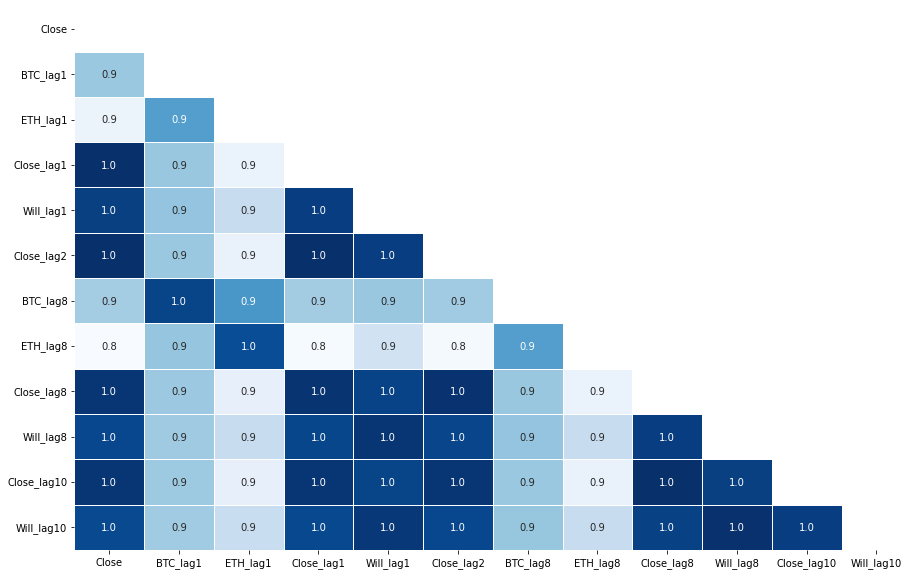

In [172]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_shifted_raw, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_shifted_raw, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

Les correlations sont vérifiées et globalement pour celles >=0.5, incrémentées de +- 0.1/0.2, converti en base 1000

In [173]:
predictors_df_shifted_raw = pps.predictors(df_shifted_raw.drop(columns=["Date","CBBTCUSD","CBETHUSD","WILL5000PR"]), y='Close')
predictors_df_shifted_raw

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Close_lag1,Close,0.963932,regression,True,mean absolute error,3071.686858,110.791122,DecisionTreeRegressor()
1,Close_lag2,Close,0.951126,regression,True,mean absolute error,3071.412682,150.112919,DecisionTreeRegressor()
2,Close_lag8,Close,0.911869,regression,True,mean absolute error,3069.839684,270.547933,DecisionTreeRegressor()
3,Close_lag10,Close,0.902646,regression,True,mean absolute error,3069.302327,298.809963,DecisionTreeRegressor()
4,Will_lag1,Close,0.878883,regression,True,mean absolute error,3071.686858,372.033370,DecisionTreeRegressor()
5,Will_lag8,Close,0.842320,regression,True,mean absolute error,3069.839684,484.052155,DecisionTreeRegressor()
6,Will_lag10,Close,0.831708,regression,True,mean absolute error,3069.302327,516.538367,DecisionTreeRegressor()
7,BTC_lag1,Close,0.758806,regression,True,mean absolute error,2990.108546,721.195933,DecisionTreeRegressor()
8,BTC_lag8,Close,0.740590,regression,True,mean absolute error,2990.027217,775.641780,DecisionTreeRegressor()
9,ETH_lag1,Close,0.622637,regression,True,mean absolute error,2947.759742,1112.374183,DecisionTreeRegressor()


[Text(0, 0, '0.963932'),
 Text(0, 0, '0.951126'),
 Text(0, 0, '0.911869'),
 Text(0, 0, '0.902646'),
 Text(0, 0, '0.878883'),
 Text(0, 0, '0.84232'),
 Text(0, 0, '0.831708'),
 Text(0, 0, '0.758806'),
 Text(0, 0, '0.74059'),
 Text(0, 0, '0.622637'),
 Text(0, 0, '0.601055')]

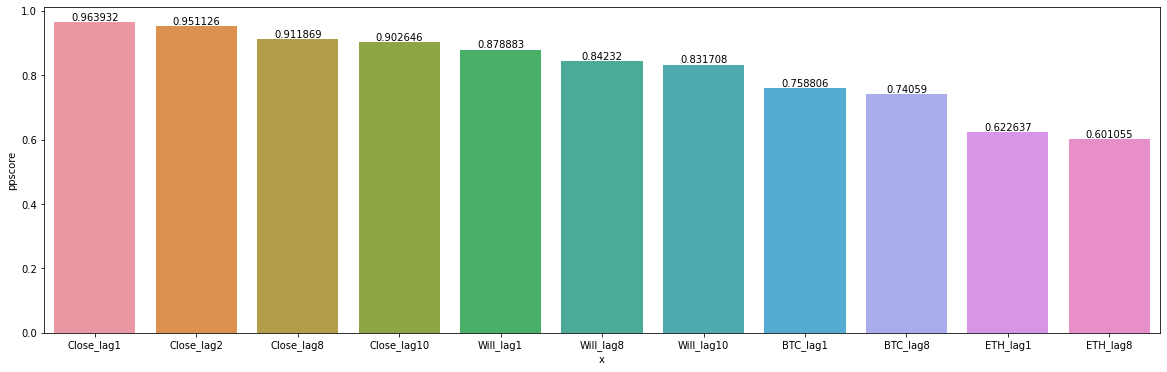

In [174]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_shifted_raw, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

A faire : Lag base 1000